<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/08_pytorch_paper_replicating_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercises

> **Note:** These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**

* [Exercise template notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb).
* [Example solutions notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/08_pytorch_paper_replicating_exercise_solutions.ipynb) (try the exercises *before* looking at this).
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/tjpW_BY8y3g) (errors and all).

# import/dataloaders

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 23.38 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d22c0197730>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

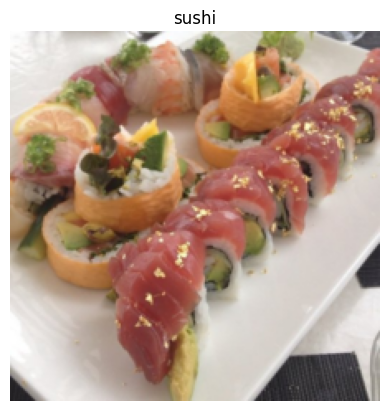

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).


* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).


In [9]:
# patchify images using conv2d
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image_convd = conv2d(image.unsqueeze(0))
image_convd.shape

torch.Size([1, 768, 14, 14])

showing the conv feature maps from indexes: range(0, 14)


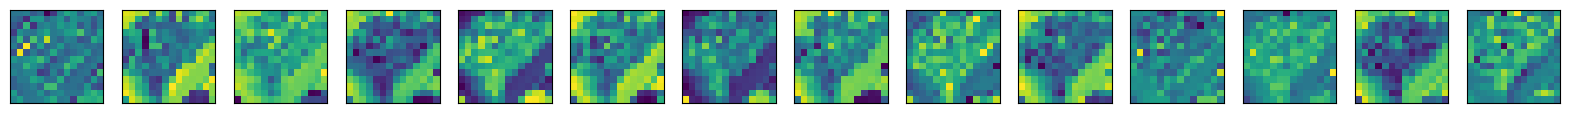

In [10]:
# view image_convd. well atleast the first row
fig, axs = plt.subplots(nrows=1, ncols=14, figsize=(20,20))

print(f"showing the conv feature maps from indexes: {range(0,14)}")
for i, idx in enumerate(range(0,14)):
    image_conv_feature_map = image_convd[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [11]:
# flatten the convd image into 1x1 of [batch, embedding_dims, height, width]
flatten = nn.Flatten(start_dim=2,# flatten height
                     end_dim=3)# flatten width

image_convd_flattened = flatten(image_convd)
image_convd_flattened.shape

torch.Size([1, 768, 196])

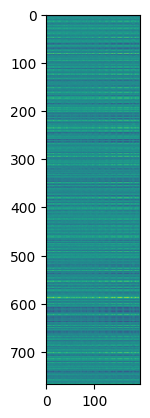

In [12]:
plt.imshow(image_convd_flattened.squeeze().detach().numpy())


torch.Size([1, 196, 768])

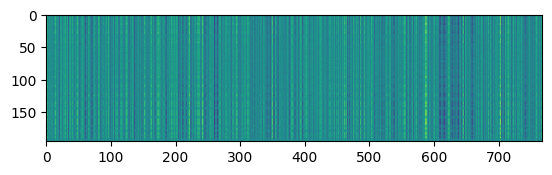

In [13]:
# permutte to change it from [batch, embedded_dim, number_of_patches] to [batch, num_patches, embedded_dim]
image_convd_flattened_reshaped = image_convd_flattened.permute(0, 2, 1)
plt.imshow(image_convd_flattened_reshaped.squeeze().detach().numpy())
image_convd_flattened_reshaped.shape

In [14]:
# add extra learnable class token
# get the batch size and embedding dim
batch_size = image_convd_flattened_reshaped.shape[0]
embedding_dim = image_convd_flattened_reshaped.shape[-1]

# create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                           requires_grad=True)

print(f"Patched image shape before adding class token: {image_convd_flattened_reshaped.shape}")
print(f"Class token shape: {class_token.shape}")

# prepend class token
patched_image_with_class_embedding = torch.cat((class_token, image_convd_flattened_reshaped),
                                               dim=1)

print(f"Patched image shape after adding class token: {patched_image_with_class_embedding.shape}")

Patched image shape before adding class token: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patched image shape after adding class token: torch.Size([1, 197, 768])


In [15]:
height, width = image.shape[-2], image.shape[-1]
(height*width) / patch_size**2

196.0

In [16]:
# adding positional embeddings
batch_size = patched_image_with_class_embedding.shape[0]
embedding_dim = patched_image_with_class_embedding.shape[-1]
height, width = image.shape[-2], image.shape[-1]
num_patches = int((height*width) / patch_size**2)

# create positional embedding as a learnable parameter
position_embeddings = nn.Parameter(torch.randn(batch_size, num_patches+1, embedding_dim),
                           requires_grad=True)

patch_plus_position_embedding = patched_image_with_class_embedding + position_embeddings
patch_plus_position_embedding.shape

torch.Size([1, 197, 768])

In [17]:
# putting it all together
class EquationOne(nn.Module):
    def __init__(self,
                 image_size:int=224,
                 patch_size:int=16,
                 in_channels:int=3,
                 embedding_dim:int=768):
        super().__init__()

        assert image_size % patch_size == 0, f"Error: image_size ({image_size}) is not divisible by patch_size ({patch_size})"

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        num_patches = int((image_size * image_size) / patch_size**2)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim),
                                            requires_grad=True)

    def forward(self, x):
        x = self.flatten(self.patcher(x))
        x = x.permute(0,2,1)
        x = torch.cat((self.class_token, x), dim=1)
        x = x + self.position_embedding
        return x



In [18]:
x = image.unsqueeze(0)
patchifier = EquationOne()
x_patchified = patchifier(x)
x_patchified.shape

torch.Size([1, 197, 768])

# 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.


* You should be able to import an entire ViT model using something like`from vit import ViT`.


# 3. Train a pretrained ViT feature extractor model

(like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets).
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).


# 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights

from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* **Note:** ViT pretrained with SWAG weights has a minimum input image size of `(384, 384)` (the pretrained ViT in exercise 3 has a minimum input size of `(224, 224)`), though this is accessible in the weights `.transforms()` method.


# 5. Research some of the following topics from Table 3

 in the ViT paper that we miss and write a sentence about each and how it might help with training:
* ImageNet-21k pretraining (more data).
* Learning rate warmup.
* Learning rate decay.
* Gradient clipping.